In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pd.set_option('max_columns', 200)
%matplotlib inline


from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [3]:
# import data
data_week = pd.read_csv('/content/drive/MyDrive/Data/date_to_week_id_map.csv')
product = pd.read_csv('/content/drive/MyDrive/Data/product_prices.csv')

In [4]:
data_week.head()

,date,week_id
0,2012-01-01,49
1,2012-01-02,49
2,2012-01-03,49
3,2012-01-04,49
4,2012-01-05,49


In [5]:
product.head()

,outlet,product_identifier,week_id,sell_price
0,111,74,49,2.94
1,111,74,50,2.94
2,111,74,51,2.94
3,111,74,52,2.94
4,111,74,53,2.94


In [6]:
# merge both data
merged_data = pd.merge(product,data_week, on=['week_id'], how='inner')
merged_data.head()

,outlet,product_identifier,week_id,sell_price,date
0,111,74,49,2.94,2012-01-01
1,111,74,49,2.94,2012-01-02
2,111,74,49,2.94,2012-01-03
3,111,74,49,2.94,2012-01-04
4,111,74,49,2.94,2012-01-05


In [7]:
# import train and test data
train_df = pd.read_csv('/content/drive/MyDrive/Data/train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Data/test_data.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Data/sample_submission.csv')

In [8]:
train_df.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales
0,2012-01-01,74,11,others,111,Maharashtra,0
1,2012-01-01,337,11,others,111,Maharashtra,1
2,2012-01-01,423,12,others,111,Maharashtra,0
3,2012-01-01,432,12,others,111,Maharashtra,0
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0


In [9]:
test_df.head()

,id,date,product_identifier,department_identifier,category_of_product,outlet,state
0,1,2014-03-01,74,11,others,111,Maharashtra
1,2,2014-03-01,337,11,others,111,Maharashtra
2,3,2014-03-01,423,12,others,111,Maharashtra
3,4,2014-03-01,432,12,others,111,Maharashtra
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra


In [10]:
sample_submission.head()

,id,sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [11]:
# we will be merging the merged_date to train_df
train_df = pd.merge(train_df,merged_data, on=['date','product_identifier','outlet'], how='inner')

In [12]:
train_df.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88


In [13]:
# # we will be merging the merged_date to test_df
test_df = pd.merge(test_df,merged_data, on=['date','product_identifier','outlet'], how='inner')

In [14]:
test_df.head()

,id,date,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price
0,1,2014-03-01,74,11,others,111,Maharashtra,162,3.43
1,2,2014-03-01,337,11,others,111,Maharashtra,162,7.78
2,3,2014-03-01,423,12,others,111,Maharashtra,162,0.97
3,4,2014-03-01,432,12,others,111,Maharashtra,162,4.97
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra,162,4.88


In [15]:
print(train_df.shape)
print(test_df.shape)

(395000, 9)
(15500, 9)


## EDA ON TRAIN DATA

In [16]:
# missing data
train_df.isnull().sum()

,0
date,0
product_identifier,0
department_identifier,0
category_of_product,0
outlet,0
state,0
sales,0
week_id,0
sell_price,0


In [17]:
# data info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395000 entries, 0 to 394999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   395000 non-null  object 
 1   product_identifier     395000 non-null  int64  
 2   department_identifier  395000 non-null  int64  
 3   category_of_product    395000 non-null  object 
 4   outlet                 395000 non-null  int64  
 5   state                  395000 non-null  object 
 6   sales                  395000 non-null  int64  
 7   week_id                395000 non-null  int64  
 8   sell_price             395000 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 27.1+ MB


In [18]:
# convert the date column to datatype
import datetime as dt
train_df['date'] = pd.to_datetime(train_df['date'])

# extract the year, month and quarter in the date column
train_df['date_year'] = train_df['date'].dt.year # the data contains 3 years stock prices 2011, 2012, 2013
train_df['days_in_month'] = train_df['date'].dt.month # where 1 == January, 2 = Febuary, ... December == 12
train_df['quarter'] = train_df['date'].dt.quarter # in a year we have 4 quaters 1, 2, 3, 4
train_df['weekday'] = train_df['date'].dt.weekday # where Monday == 0, Tuesday == 1, ... Sunday == 6

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395000 entries, 0 to 394999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   395000 non-null  datetime64[ns]
 1   product_identifier     395000 non-null  int64         
 2   department_identifier  395000 non-null  int64         
 3   category_of_product    395000 non-null  object        
 4   outlet                 395000 non-null  int64         
 5   state                  395000 non-null  object        
 6   sales                  395000 non-null  int64         
 7   week_id                395000 non-null  int64         
 8   sell_price             395000 non-null  float64       
 9   date_year              395000 non-null  int32         
 10  days_in_month          395000 non-null  int32         
 11  quarter                395000 non-null  int32         
 12  weekday                395000 non-null  int3

In [20]:
# Here i used strftime to extract the day and month name of my date for my analysis
train_df['date_info'] = train_df['date'].dt.strftime('%d-%A-%B-%Y') # create a ne column data_info to store my strftime date
train_df['dayname'] = train_df['date_info'].str.split('-', expand = True)[1] # assign the day name
train_df['mnthname'] = train_df['date_info'].str.split('-', expand = True)[2] # assisgn the month name
train_df['year_str'] = train_df['date_info'].str.split('-', expand = True)[3] # assisgn the month name

In [21]:
# # drop the date_info, date, department_identifiercolumn
# train_df.drop(['date_info', 'department_identifier'],  axis = 1, inplace = True)

In [22]:
train_df.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price,date_year,days_in_month,quarter,weekday,date_info,dayname,mnthname,year_str
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94,2012,1,1,6,01-Sunday-January-2012,Sunday,January,2012
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44,2012,1,1,6,01-Sunday-January-2012,Sunday,January,2012
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97,2012,1,1,6,01-Sunday-January-2012,Sunday,January,2012
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97,2012,1,1,6,01-Sunday-January-2012,Sunday,January,2012
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88,2012,1,1,6,01-Sunday-January-2012,Sunday,January,2012


In [23]:
# let check the category of date we have
print(f'We have {train_df["category_of_product"].nunique()} unique categories of products')

We have 3 unique categories of products


In [24]:
# check the value counts of each category of date
train_df["category_of_product"].value_counts()

,count
category_of_product,
fast_moving_consumer_goods,229100
drinks_and_food,134300
others,31600


In [25]:
# check number of outlets for this company in India
print(f'We have {train_df["outlet"].nunique()} unique outlets')

We have 10 unique outlets


In [26]:
# check the value counts of each outlet
# train_df["outlet"].value_counts()

In [27]:
# check the number states the company is located in india
print(f'The company is located in {train_df["state"].nunique()} states across India')

The company is located in 3 states across India


In [28]:
# list the states the company is located in India
train_df["state"].value_counts().index.tolist()

['Maharashtra', 'Telangana', 'Kerala']

In [29]:
# check the statistics of the numerical data
train_df.describe()

,date,product_identifier,department_identifier,outlet,sales,week_id,sell_price,date_year,days_in_month,quarter,weekday
count,395000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000
mean,2013-01-29 12:00:00,1509.960000,24.460000,211.200000,1.228919,105.070886,4.987644,2012.611392,6.143038,2.394937,2.997468
min,2012-01-01 00:00:00,74.000000,11.000000,111.000000,0.000000,49.000000,0.050000,2012.000000,1.000000,1.000000,0.000000
25%,2012-07-16 00:00:00,926.000000,21.000000,113.000000,0.000000,77.000000,2.680000,2012.000000,3.000000,1.000000,1.000000
50%,2013-01-29 12:00:00,1325.000000,22.000000,221.500000,0.000000,105.000000,3.980000,2013.000000,6.000000,2.000000,3.000000
75%,2013-08-15 00:00:00,1753.000000,31.000000,331.000000,1.000000,133.000000,6.480000,2013.000000,9.000000,3.000000,5.000000
max,2014-02-28 00:00:00,3021.000000,33.000000,333.000000,293.000000,161.000000,44.360000,2014.000000,12.000000,4.000000,6.000000
std,NaN,809.799518,6.337863,91.161291,3.595266,32.578749,3.874444,0.622061,3.576092,1.145593,2.000001


## DATA VISUALIZATION

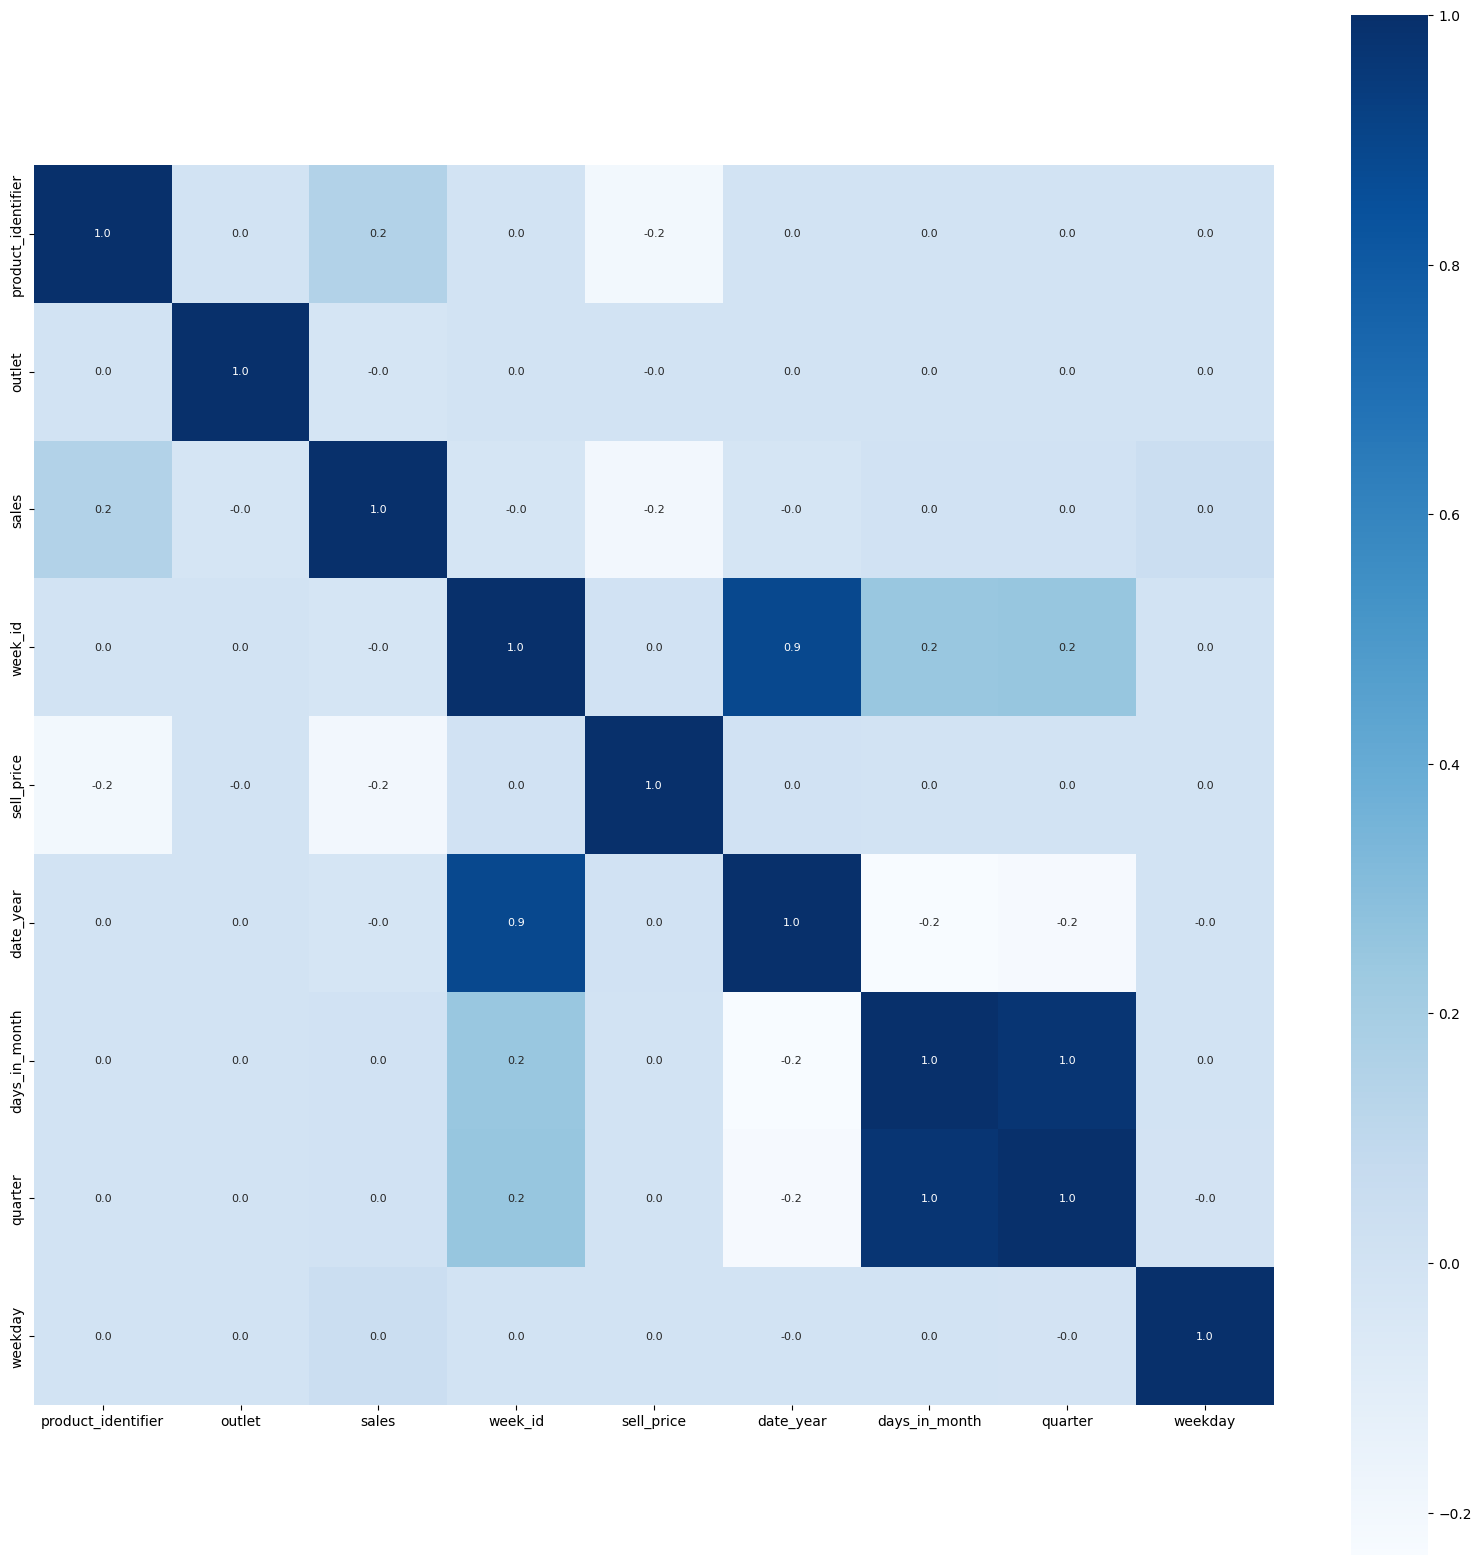

In [30]:
# let check the correlations of the features in our data
num_data = ['product_identifier', 'outlet', 'sales', 'week_id', 'sell_price', 'date_year', 'days_in_month', 'quarter', 'weekday']
train_num = train_df[num_data]
correlation = train_num.corr()
# train_num.head()


#constructing a heat  to understand the correlation
plt.figure(figsize=(20,20))
sns.heatmap(correlation, cbar=True,square = True, fmt = '.1f', annot = True, annot_kws={'size':8}, cmap='Blues');

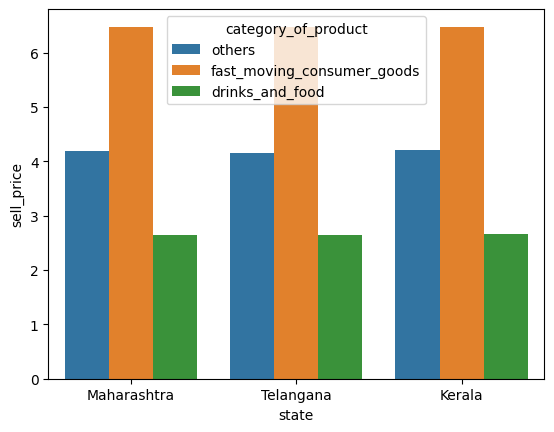

In [31]:
# Total sales by states and category of products
# check for sales across states by product category
sns.barplot(x = 'state',
            y = 'sell_price',
            hue = 'category_of_product',
            data = train_df,
            # estimator = np.median,
            errorbar=('ci', 0));

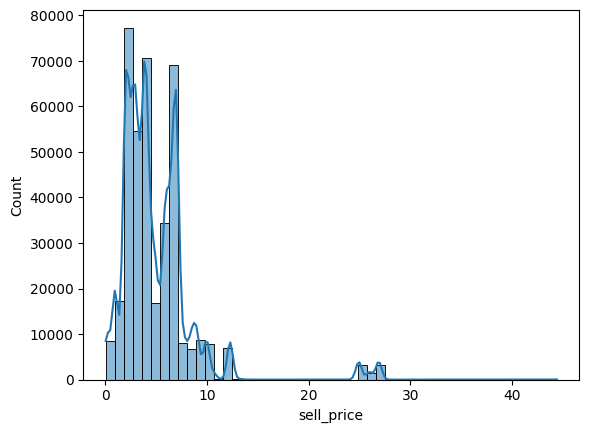

In [32]:
# Distribution count of sell price
sns.histplot(data=train_df, x="sell_price", kde=True, bins=50);

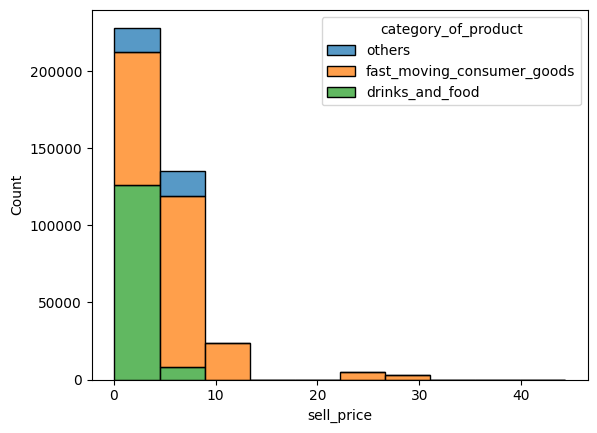

In [33]:
# Total sell price by product category
sns.histplot(data=train_df, x="sell_price", hue="category_of_product", multiple="stack", bins=10);

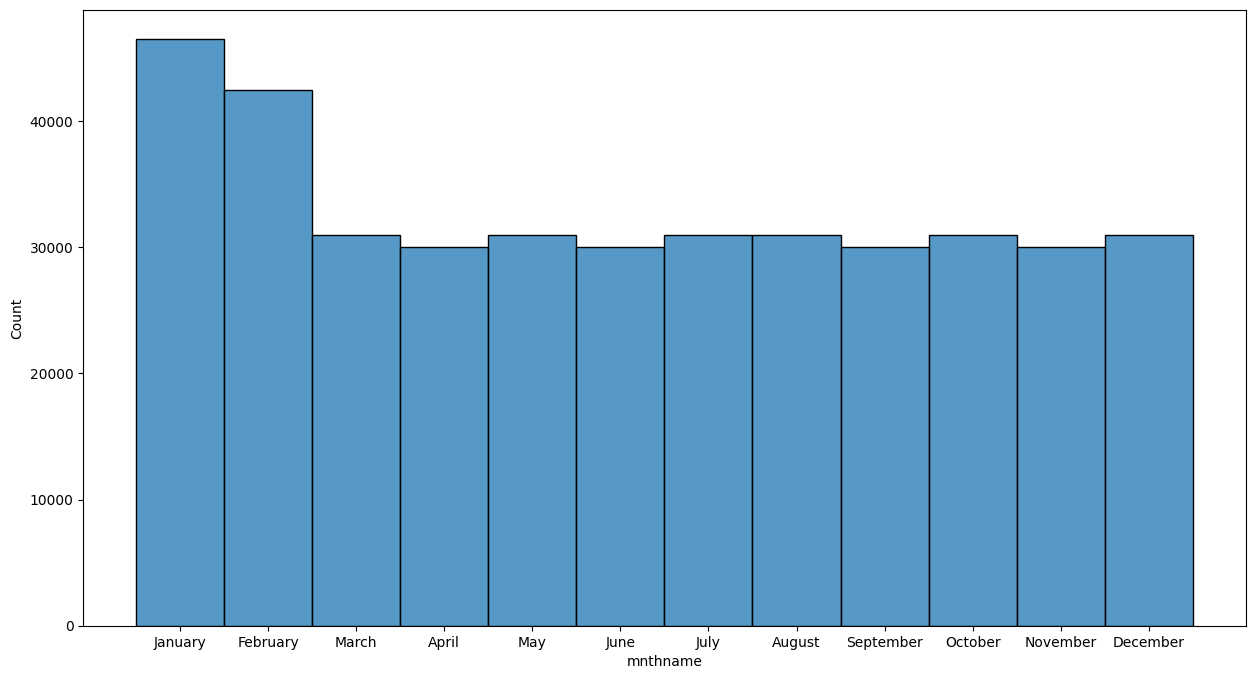

In [34]:
# Count of monthy sales
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(data=train_df, x="mnthname", bins=10, ax = ax);

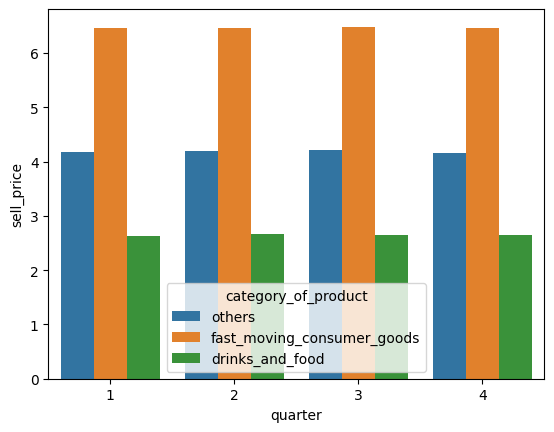

In [35]:
# Total Sell price by quarters and category of sales
# check for sales across quarters by product category
sns.barplot(x = 'quarter',
            y = 'sell_price',
            hue = 'category_of_product',
            data = train_df,
            # estimator = np.median,
            errorbar=('ci', 0));

In [36]:
train_df.groupby('state')['sell_price'].sum()

,sell_price
state,
Kerala,591171.32
Maharashtra,788347.05
Telangana,590600.83


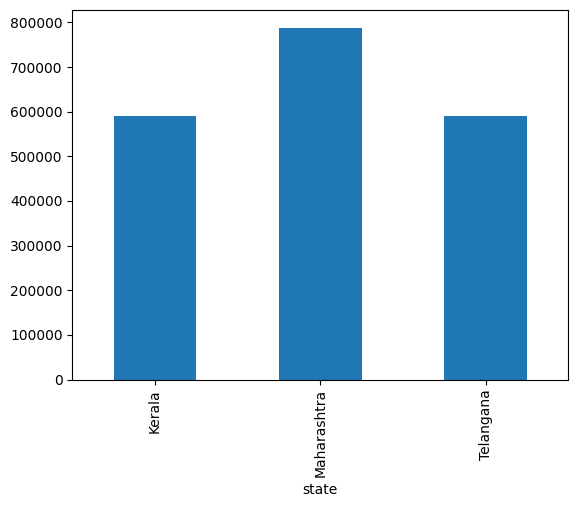

In [37]:
# Total sell price by State
train_df.groupby('state')['sell_price'].sum().plot(kind = 'bar');

In [38]:
train_df.groupby('year_str')['sell_price'].sum()

,sell_price
year_str,
2012,908199.84
2013,915250.91
2014,146668.45


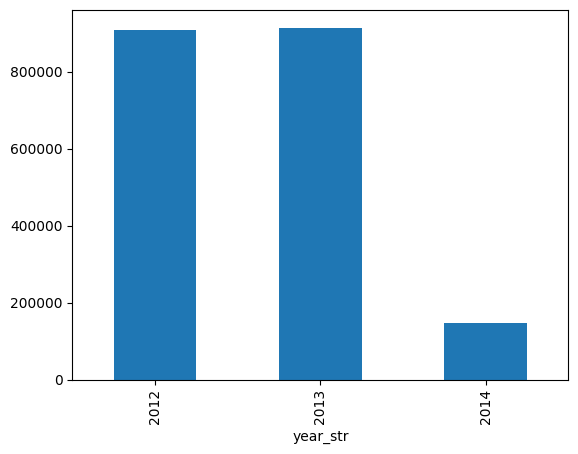

In [39]:
# yearly tolatl sell price
train_df.groupby('year_str')['sell_price'].sum().plot(kind = 'bar'); #figsize=(10,6))

In [40]:
train_df.groupby('mnthname')['sell_price'].sum()

,sell_price
mnthname,
April,149699.47
August,154738.51
December,154695.57
February,211637.06
January,231190.09
July,155577.12
June,149870.97
March,154845.92
May,154665.11


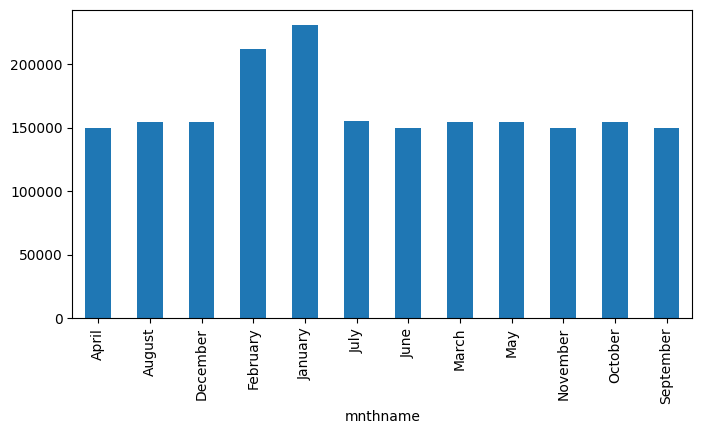

In [41]:
plt.figure(figsize=(8,4))
train_df.groupby('mnthname')['sell_price'].sum().plot(kind = 'bar');

In [42]:
# train_df.groupby('dayname')['sell_price'].sum()

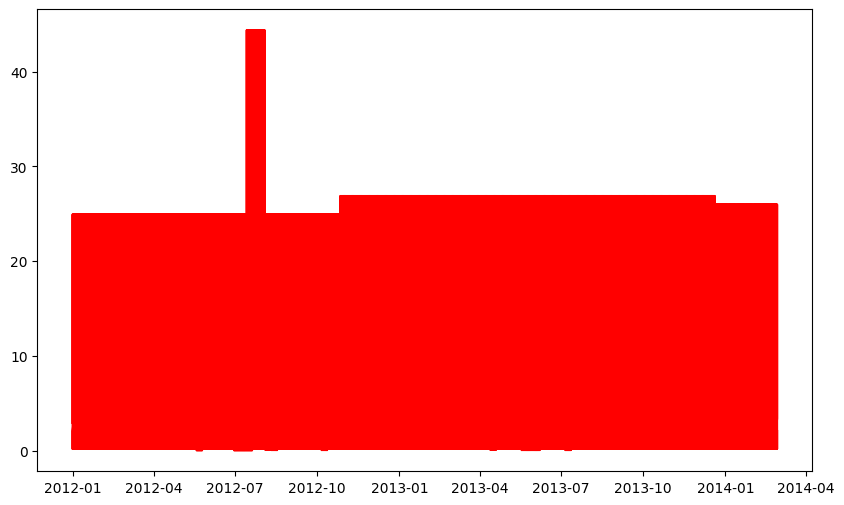

In [43]:
plt.figure(figsize=(10,6))
plt.plot(train_df.date, train_df.sell_price, color='red');

In [44]:
# drop columes not needed on train fataframe
# train_df.columns

In [45]:
# get the target data
target = train_df['sales']

In [46]:
target

,sales
0,0
1,1
2,0
3,0
4,0
...,...
394995,2
394996,8
394997,0
394998,0


In [47]:
# # drop the date_info, date, department_identifiercolumn
train_df.drop(['date_info', 'department_identifier', 'dayname', 'mnthname', 'year_str', 'date_year'],  axis = 1, inplace = True)

In [48]:
train_df.head()

,date,product_identifier,category_of_product,outlet,state,sales,week_id,sell_price,days_in_month,quarter,weekday
0,2012-01-01,74,others,111,Maharashtra,0,49,2.94,1,1,6
1,2012-01-01,337,others,111,Maharashtra,1,49,7.44,1,1,6
2,2012-01-01,423,others,111,Maharashtra,0,49,0.97,1,1,6
3,2012-01-01,432,others,111,Maharashtra,0,49,4.97,1,1,6
4,2012-01-01,581,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88,1,1,6


In [49]:
# train_df.info()

## EDA ON TEST DATA

In [50]:
test_df.head()

,id,date,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price
0,1,2014-03-01,74,11,others,111,Maharashtra,162,3.43
1,2,2014-03-01,337,11,others,111,Maharashtra,162,7.78
2,3,2014-03-01,423,12,others,111,Maharashtra,162,0.97
3,4,2014-03-01,432,12,others,111,Maharashtra,162,4.97
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra,162,4.88


In [51]:
# convert date column to date datatype
test_df['date'] = pd.to_datetime(test_df['date'])

# extract the year, month and quarter in the date column
test_df['date_year'] = test_df['date'].dt.year # the data contains 3 years stock prices 2011, 2012, 2013
test_df['days_in_month'] = test_df['date'].dt.month # where 1 == January, 2 = Febuary, ... December == 12
test_df['quarter'] = test_df['date'].dt.quarter # in a year we have 4 quaters 1, 2, 3, 4
test_df['weekday'] = test_df['date'].dt.weekday # where Monday == 0, Tuesday == 1, ... Sunday == 6

In [52]:
# test_df.head()

In [53]:
# # drop the date_info, date, department_identifiercolumn
test_df.drop(['department_identifier', 'date_year'],  axis = 1, inplace = True)

In [54]:
print(train_df.shape)
print(test_df.shape)

(395000, 11)
(15500, 11)


In [55]:
test_df.head()

,id,date,product_identifier,category_of_product,outlet,state,week_id,sell_price,days_in_month,quarter,weekday
0,1,2014-03-01,74,others,111,Maharashtra,162,3.43,3,1,5
1,2,2014-03-01,337,others,111,Maharashtra,162,7.78,3,1,5
2,3,2014-03-01,423,others,111,Maharashtra,162,0.97,3,1,5
3,4,2014-03-01,432,others,111,Maharashtra,162,4.97,3,1,5
4,5,2014-03-01,581,fast_moving_consumer_goods,111,Maharashtra,162,4.88,3,1,5


In [56]:
print(train_df.columns)
print(test_df.columns)

Index(['date', 'product_identifier', 'category_of_product', 'outlet', 'state',
       'sales', 'week_id', 'sell_price', 'days_in_month', 'quarter',
       'weekday'],
      dtype='object')
Index(['id', 'date', 'product_identifier', 'category_of_product', 'outlet',
       'state', 'week_id', 'sell_price', 'days_in_month', 'quarter',
       'weekday'],
      dtype='object')


In [57]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395000 entries, 0 to 394999
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 395000 non-null  datetime64[ns]
 1   product_identifier   395000 non-null  int64         
 2   category_of_product  395000 non-null  object        
 3   outlet               395000 non-null  int64         
 4   state                395000 non-null  object        
 5   sales                395000 non-null  int64         
 6   week_id              395000 non-null  int64         
 7   sell_price           395000 non-null  float64       
 8   days_in_month        395000 non-null  int32         
 9   quarter              395000 non-null  int32         
 10  weekday              395000 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(4), object(2)
memory usage: 28.6+ MB


In [58]:
# numerical and categorical features of train data
num_feat = ['outlet', 'week_id', 'sell_price', 'days_in_month', 'quarter', 'weekday']
cat_feat = ['category_of_product', 'state']

In [59]:
test_df[cat_feat].head()

,category_of_product,state
0,others,Maharashtra
1,others,Maharashtra
2,others,Maharashtra
3,others,Maharashtra
4,fast_moving_consumer_goods,Maharashtra


## TIME SERIES MODEL USING PROPHET
Prophet is an open-source tool released by Facebook's Data Science team that produces time series forecasting data based on an additive model where a non-linear trend fits with seasonality and holiday effects.

Prophet requires two specific columns as input data. ‘ds’ and ‘y’ columns should be included in the data and these two columns represent the date and the variable that will be forecasted.

In [60]:
# import prophets library
from prophet import Prophet

In [61]:
# Prophet requires two specific columns as input.
# In this case we will be using date column and sell_price

train_prophet = train_df[['date', 'sell_price']]

## Decomposing training Data
For this, we import the method from statsmodels library

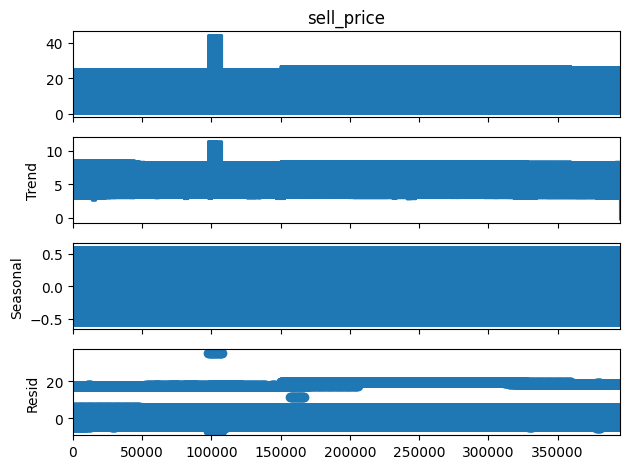

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(train_prophet.sell_price, model='additive', extrapolate_trend='freq', period=12)

decompose.plot().show()

In [63]:
# Prophet expects the data to follow a specific format
# The date be rename as ds and the target column as y
train_prophet.columns = ['ds', 'y']

In [64]:
# view column
train_prophet.head()

,ds,y
0,2012-01-01,2.94
1,2012-01-01,7.44
2,2012-01-01,0.97
3,2012-01-01,4.97
4,2012-01-01,4.88


In [65]:
train_prophet.shape

(395000, 2)

## Model fitting with Facebook Prophet
To fit models in Prophet, it is important to have at least a ‘ds’ (datestamp) and ‘y’ (value to be forecasted) column)

In [66]:
model_prophet  = Prophet() # Creating the model that indicates there will be a logistic growth.
model_prophet.fit(train_prophet) # Fitting our data to the model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf4mn2wyu/n3027hnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf4mn2wyu/0k5s24nr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20384', 'data', 'file=/tmp/tmpf4mn2wyu/n3027hnf.json', 'init=/tmp/tmpf4mn2wyu/0k5s24nr.json', 'output', 'file=/tmp/tmpf4mn2wyu/prophet_model_iuf8yl4/prophet_model-20241102125517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:55:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:55:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Making Predictions

We wil be making use of the `make_future_dataframe method`, and it will automatically include historical dates.

In [67]:
# Creating the Future Dataset
df_future = model_prophet.make_future_dataframe(periods=365, freq='MS') # Creating the future dataframe
# Periods is number of days (1 year) that you want to forecast
display(df_future)

,ds
0,2012-01-01
1,2012-01-02
2,2012-01-03
3,2012-01-04
4,2012-01-05
...,...
1150,2044-03-01
1151,2044-04-01
1152,2044-05-01
1153,2044-06-01


In [68]:
# Make prediction
forecast_prophet = model_prophet.predict(df_future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
1150,2044-03-01,-0.0,-14.0,13.0
1151,2044-04-01,-0.0,-14.0,14.0
1152,2044-05-01,-0.0,-14.0,14.0
1153,2044-06-01,-0.0,-14.0,14.0
1154,2044-07-01,-0.0,-14.0,15.0


'The chart show the trend, weekly and yearly trend of the sell price. As can be seen in the trend chart, there is a decline in sell price, the weekly trend shows the company has highest sell price on Sunday then on Friday the sell price is low. For the Yearly trend, we can see that the highest sell price is between July 1 and August 1, the low sell price is seen by November 1.'

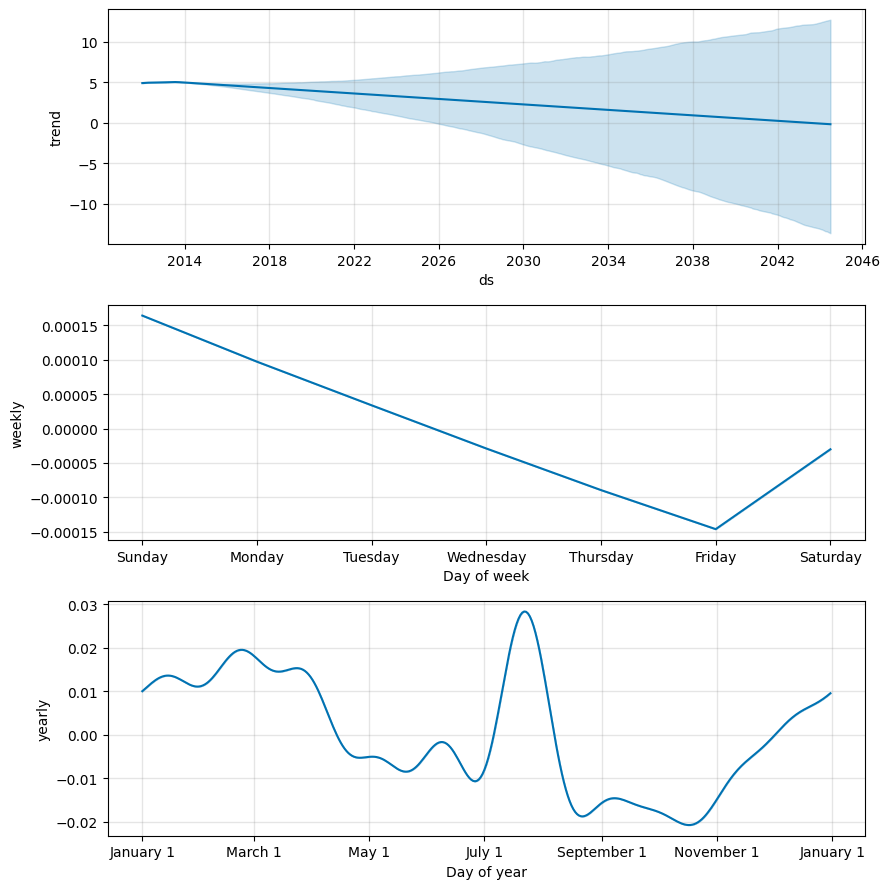

In [69]:
# Plot predited component
fig2 = model_prophet.plot_components(forecast_prophet)
"""The chart show the trend, weekly and yearly trend of the sell price. As can be seen in the trend chart, there is a decline in sell price, the weekly trend shows the company has highest sell price on Sunday then on Friday the sell price is low. For the Yearly trend, we can see that the highest sell price is between July 1 and August 1, the low sell price is seen by November 1."""

In [70]:
"""In this problem i am tasked with building a machine learning model to predict the sales of products across stores for one month"""

# Creating the Future Dataset for 1 month
df_future_mnth = model_prophet.make_future_dataframe(periods=31) # Creating the future dataframe
# Periods is number of days (1 month) that you want to forecast
display(df_future_mnth)

,ds
0,2012-01-01
1,2012-01-02
2,2012-01-03
3,2012-01-04
4,2012-01-05
...,...
816,2014-03-27
817,2014-03-28
818,2014-03-29
819,2014-03-30


In [71]:
# Make prediction
forecast_prophet_mnth = model_prophet.predict(df_future_mnth)
forecast_prophet_mnth[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
816,2014-03-27,5.0,0.0,10.0
817,2014-03-28,5.0,-0.0,10.0
818,2014-03-29,5.0,0.0,10.0
819,2014-03-30,5.0,-0.0,10.0
820,2014-03-31,5.0,0.0,10.0


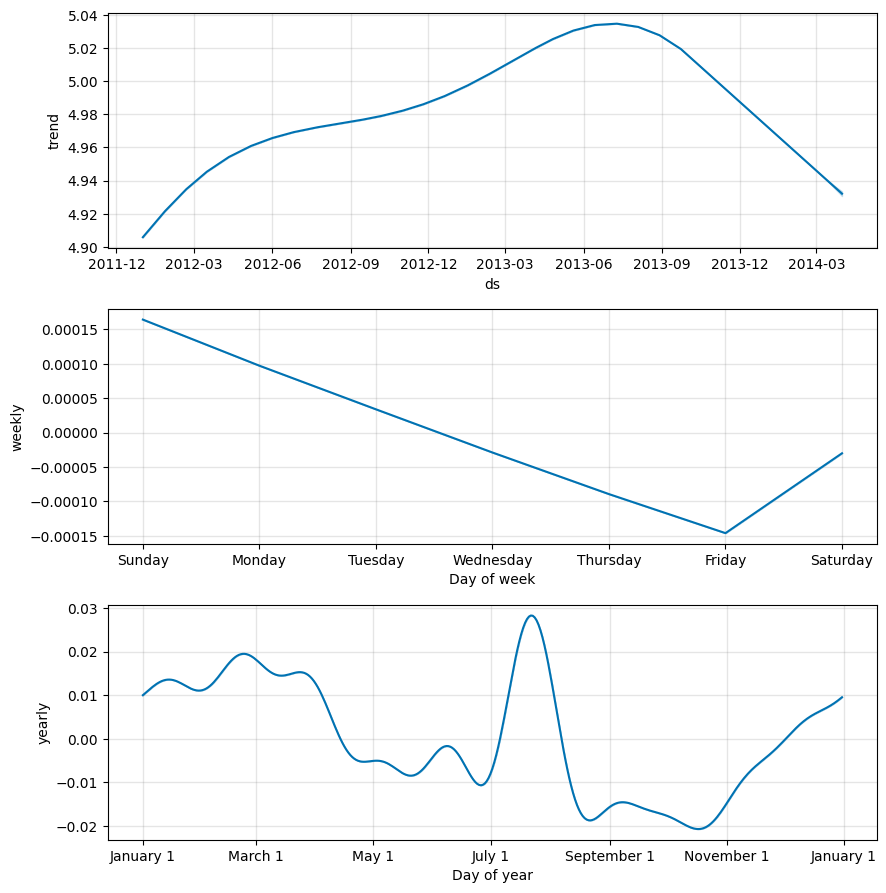

In [72]:
# Plot predited component
fig2 = model_prophet.plot_components(forecast_prophet_mnth)